In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_array, check_X_y
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import cross_val_score, train_test_split

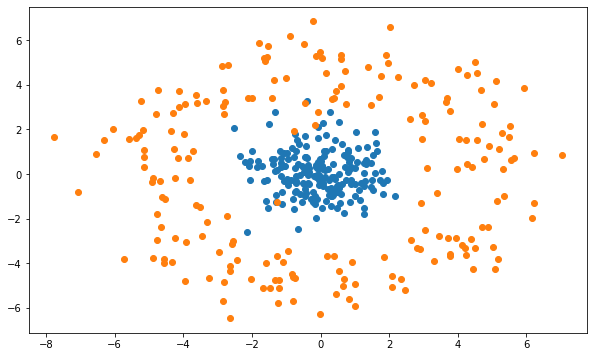

In [67]:
n = 200
theta = np.random.uniform(low=0, high=2*np.pi, size=n)
r = np.random.normal(5, 1, size=n)
X0 = np.array([r*np.cos(theta), r*np.sin(theta)]).T
X1 = np.random.multivariate_normal([0,0], np.identity(2), size=n)
X = np.concatenate([X0, X1], axis=0)
y = np.concatenate([np.zeros(200), np.ones(200)], axis=0)
I = np.arange(2*n)
np.random.shuffle(I)
X = X[I,:]
y = y[I]

plt.figure(figsize=(10, 6))    
plt.plot(X[y == 1,0], X[y == 1,1], 'o')
plt.plot(X[y == 0,0], X[y == 0,1], 'o')

In [46]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

print(X_tr.shape, X_te.shape, y_tr.shape, y_te.shape)

(320, 2) (80, 2) (320,) (80,)


k_opt = 8
accuracy: 0.9875
(50, 50, 2)


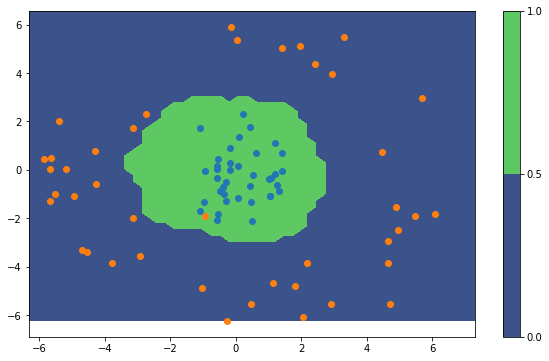

In [64]:
scores = []
ks = np.arange(1, 20)
for k in ks:
    M = KNeighborsClassifier(n_neighbors=k)
    score = np.mean(cross_val_score(M, X_tr, y_tr, cv=5, scoring="accuracy"))
    scores.append(score)

k_opt = ks[np.argmax(scores)]
print(f"k_opt = {k_opt}")

M = KNeighborsClassifier(n_neighbors=k_opt)
M.fit(X_tr, y_tr)
y_p = M.predict(X_te)
acc = np.sum(y_p == y_te)/len(y_te)
print(f"accuracy: {acc:.4}")

xmin = X.min(axis=0)
xmax = X.max(axis=0)
u = np.linspace(xmin[0], xmax[0], 50)
v = np.linspace(xmin[1], xmax[1], 50)

U, V = np.meshgrid(u, v)
UV = np.stack([U, V], axis=-1)
print(UV.shape)
W = np.zeros_like(U)

for j in range(50):
    W[:, j] = M.predict(UV[:, j, :])

plt.figure(figsize=(10, 6))    
c = plt.contourf(U, V, W, levels=[0, 0.5, 1])
plt.colorbar(c);
plt.plot(X_te[y_te == 1, 0], X_te[y_te == 1, 1], 'o')
plt.plot(X_te[y_te == 0, 0], X_te[y_te == 0, 1], 'o');

accuracy: 0.55
(50, 50, 2)


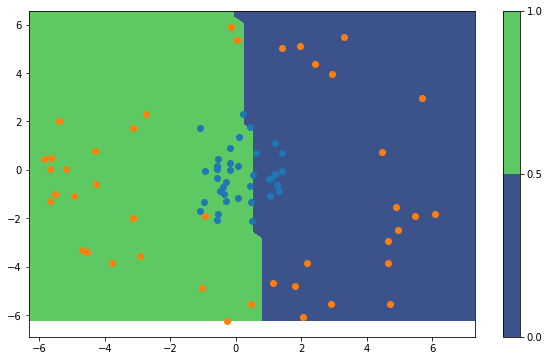

In [65]:
M = LogisticRegression(solver="lbfgs")
M.fit(X_tr, y_tr)
y_p = M.predict(X_te)
acc = np.sum(y_p == y_te)/len(y_te)
print(f"accuracy: {acc:.4}")

xmin = X.min(axis=0)
xmax = X.max(axis=0)
u = np.linspace(xmin[0], xmax[0], 50)
v = np.linspace(xmin[1], xmax[1], 50)

U, V = np.meshgrid(u, v)
UV = np.stack([U, V], axis=-1)
print(UV.shape)
W = np.zeros_like(U)

for j in range(50):
    W[:, j] = M.predict(UV[:, j, :])

plt.figure(figsize=(10, 6))    
c = plt.contourf(U, V, W, levels=[0, 0.5, 1])
plt.colorbar(c);
plt.plot(X_te[y_te == 1, 0], X_te[y_te == 1, 1], 'o')
plt.plot(X_te[y_te == 0, 0], X_te[y_te == 0, 1], 'o');

In [57]:
class KernelRegressor(BaseEstimator, ClassifierMixin):
    def __init__(self, K=None, h=None):
        if K is None:
            raise Exception("K cannot be None.")
        if h is None:
            raise Exception("h cannot be None.")        
        self.K = K
        self.h = h
        
    def fit(self, X, y):
        _X, _y = check_X_y(X, y)
        self._X = _X
        self._y = _y
    
    def predict_proba(self, X):
        X = check_array(X);
        dists = pairwise_distances(self._X, X)
        K_values = self.K(dists/self.h)
        return np.sum(K_values*self._y.reshape(-1, 1), axis=0)/np.sum(K_values, axis=0)
    
    def predict(self, X):
        return np.round(self.predict_proba(X))
    
def G(u):
    return np.exp(-np.square(u)/2)/np.sqrt(2*np.pi)

h_opt = 0.5
accuracy: 0.9875
(50, 50, 2)


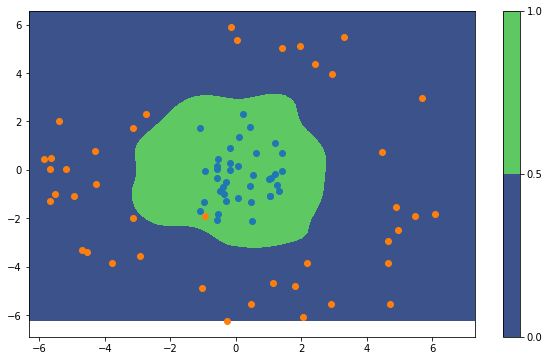

In [66]:
scores = []
hs = np.arange(0.5, 10, 0.5)
for h in hs:
    M = KernelRegressor(K=G, h=h)
    score = np.mean(cross_val_score(M, X_tr, y_tr, cv=5, scoring="accuracy"))
    scores.append(score)

h_opt = hs[np.argmax(scores)]
print(f"h_opt = {h_opt}")

M = KernelRegressor(K=G, h=h_opt)
M.fit(X_tr, y_tr)
y_p = M.predict(X_te)
acc = np.sum(np.round(y_p) == y_te)/len(y_te)
print(f"accuracy: {acc:.4}")

xmin = X.min(axis=0)
xmax = X.max(axis=0)
u = np.linspace(xmin[0], xmax[0], 50)
v = np.linspace(xmin[1], xmax[1], 50)

U, V = np.meshgrid(u, v)
UV = np.stack([U, V], axis=-1)
print(UV.shape)
W = np.zeros_like(U)

for j in range(50):
    W[:, j] = M.predict_proba(UV[:, j, :])

plt.figure(figsize=(10, 6))    
c = plt.contourf(U, V, W, levels=[0, 0.5, 1])
plt.colorbar(c);
plt.plot(X_te[y_te == 1, 0], X_te[y_te == 1, 1], 'o')
plt.plot(X_te[y_te == 0, 0], X_te[y_te == 0, 1], 'o');